In [1]:
!pip install -q pandas
!pip install -q numpy
!pip install -q matplotlib
!pip install -q scikit-learn
!pip install -q lightgbm
!pip install -q pmdarima
!pip install -q prophet


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
from lightgbm import LGBMRegressor
from prophet import Prophet

C:\Users\Zhenia\AppData\Local\Temp\ipykernel_24396\2808890991.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Zhenia\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read data
df_customers = pd.read_csv('Data/S_Data/customers.csv')
df_geo = pd.read_csv('Data/S_Data/geolocation.csv')
df_order_items = pd.read_csv('Data/S_Data/order_items.csv')
df_order_payments = pd.read_csv('Data/S_Data/order_payments.csv')
df_order_reviews = pd.read_csv('Data/S_Data/order_reviews.csv')
df_orders = pd.read_csv('Data/S_Data/orders.csv')
df_products = pd.read_csv('Data/S_Data/products.csv')
df_sellers = pd.read_csv('Data/S_Data/sellers.csv')
df_transl = pd.read_csv('Data/S_Data/product_category_name_translation.csv')

### Customers

In [4]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
df_customers["customer_unique_id"].value_counts()

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
081f07439678af2da7755a0aa572154d     1
9c57789a6a587f4efcfb01e36c106014     1
9e4c21635f640562de1a6976374fba03     1
06c0ea6ee892364d1608ee47aa9f56a0     1
84732c5050c01db9b23e19ba39899398     1
Name: count, Length: 96096, dtype: int64

In [6]:
print(df_customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None


### Geolocation

In [7]:
df_geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [8]:
df_geo.nunique()

geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

In [9]:
# Group geo data by zip code prefix and find average lat and lng for each zip code
# It will be used as feature for ml model
columns_to_show = ['geolocation_lat', 'geolocation_lng']
df_avg_geo = df_geo.groupby(['geolocation_zip_code_prefix'], group_keys=True)[columns_to_show].agg("mean").reset_index()
df_avg_geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


In [10]:
df_avg_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  int64  
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 445.8 KB


### Order items

In [11]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [12]:
df_order_items["product_id"].value_counts()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
                                   ... 
dbc42f8ad8afd0147a5a46be630781f8      1
5d86ed92606c80a89e547cdba3946812      1
0b8750fa58fefe42cf03a9e2e4b8fce6      1
a4758e74e2cdb74d0c4db83594ca14a3      1
350688d9dc1e75ff97be326363655e01      1
Name: count, Length: 32951, dtype: int64

In [13]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [14]:
df_order_items["order_id"].nunique()

98666

In [15]:
# => In one order can be several items

### Order payments

In [16]:
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [17]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [18]:
df_order_payments["order_id"].nunique()

99440

### Order reviews

In [19]:
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [20]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [21]:
df_order_reviews["order_id"].nunique()

99441

### Orders

In [22]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [23]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### Products

In [24]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [25]:
# NaN values amount in each column
print(df_products.isnull().sum())

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [26]:
print(df_products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
None


In [27]:
# Show all products categories
pd.unique(df_products["product_category_name"])

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio', nan,
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
   

### Sellers

In [28]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


# Task 1 (Demand forecasting)

## Task 1.1 (Machine Learning model)

### All product categories

In [29]:
# Find all groups (categories) of products
groups = pd.unique(df_products["product_category_name"]).tolist()
for el in groups: print(el, end=" | ")
print()

perfumaria | artes | esporte_lazer | bebes | utilidades_domesticas | instrumentos_musicais | cool_stuff | moveis_decoracao | eletrodomesticos | brinquedos | cama_mesa_banho | construcao_ferramentas_seguranca | informatica_acessorios | beleza_saude | malas_acessorios | ferramentas_jardim | moveis_escritorio | automotivo | eletronicos | fashion_calcados | telefonia | papelaria | fashion_bolsas_e_acessorios | pcs | casa_construcao | relogios_presentes | construcao_ferramentas_construcao | pet_shop | eletroportateis | agro_industria_e_comercio | nan | moveis_sala | sinalizacao_e_seguranca | climatizacao | consoles_games | livros_interesse_geral | construcao_ferramentas_ferramentas | fashion_underwear_e_moda_praia | fashion_roupa_masculina | moveis_cozinha_area_de_servico_jantar_e_jardim | industria_comercio_e_negocios | telefonia_fixa | construcao_ferramentas_iluminacao | livros_tecnicos | eletrodomesticos_2 | artigos_de_festas | bebidas | market_place | la_cuisine | construcao_ferramentas

### General dataframe of orders with all useful information

In [30]:
df = df_order_items

# Merge data about order
df = df.merge(df_orders, on='order_id', how='left')

# Merge data about order item's product info
df = df.merge(
    df_products[[
        'product_id',
        'product_category_name',
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm']],
    on='product_id',
    how='left')

# Merge data about order item's customer info
df = df.merge(
    df_customers[[
        'customer_id',
        'customer_zip_code_prefix',
        'customer_city',
        'customer_state']],
    on='customer_id',
    how='left')

# Merge data about customer's geolocationinfo
df = df.merge(
    df_avg_geo[[
        'geolocation_zip_code_prefix',
        'geolocation_lat',
        'geolocation_lng']].rename({'geolocation_zip_code_prefix': 'customer_zip_code_prefix'}, axis=1),
    on='customer_zip_code_prefix',
    how='left')

# Add data about order item's summary price
df['items_price'] = df.price * df.order_item_id

# Sort purchases dataframe by datetime
df = df.sort_values(by='order_purchase_timestamp', 
        ascending=True)

# Round date to days
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']).dt.floor('D')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112650 entries, 20265 to 37073
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   seller_id                      112650 non-null  object        
 4   shipping_limit_date            112650 non-null  object        
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   customer_id                    112650 non-null  object        
 8   order_status                   112650 non-null  object        
 9   order_purchase_timestamp       112650 non-null  datetime64[ns]
 10  order_approved_at              112635 non-null  object        
 11  or

### Exploring "perfumaria" category (for example)

***
MAE, the mean absolute error, was chosen as the metric. This metric is suitable for our highly unbalanced training sample. MAE allows you to not get huge penalties on very popular items and generally perform well on the majority of items.

We collect a training sample in which the attributes are past sales for 7 previous days, mean products price for previous 7 days, date, and mean geolocation of the customers, that bought products for 7 previous days. The targets are sales for the next week.

We trained LightGBM model on this data. It shows better perfomance than Linear Regression and Random Forest Regressor, and is faster than XGBoost.
***

In [31]:
# Prepare datatset

In [32]:
group = 'perfumaria'
data = df[df['product_category_name'] == group]

# Fill dataframe with missed dates
start_date = data["order_purchase_timestamp"].min()
end_date = data["order_purchase_timestamp"].max()
date_range = pd.date_range(start=start_date, end=end_date).to_frame(index=False, name='order_purchase_timestamp')
date_range = date_range.merge(data, on='order_purchase_timestamp', how='left')
date_range['order_item_id'] = date_range['order_item_id'].fillna(0)
date_range['price'] = date_range['price'].fillna(0)
date_range['items_price'] = date_range['items_price'].fillna(0)
date_range['geolocation_lat'] = date_range['geolocation_lat'].fillna(0)
date_range['geolocation_lng'] = date_range['geolocation_lng'].fillna(0)
data = date_range

# Group dataframe data by dates
cols_to_show = ['order_item_id', 'items_price', 'geolocation_lat', 'geolocation_lng']
# Find number of items, mean items' price, mean geolocations' lat and lng
data = data.groupby(["order_purchase_timestamp"])[cols_to_show].agg({'order_item_id': ['sum'], 'items_price': ['mean'], 'geolocation_lat': ['mean'],'geolocation_lng': ['mean']}).reset_index()
# Flat columns' names after grouping
data.columns = list(map(''.join, data.columns.values))
data = data.rename(columns={"order_item_idsum": "order_item_id", "items_pricemean": "items_mean_price", "geolocation_latmean": "geolocation_lat_mean", "geolocation_lngmean": "geolocation_lng_mean"})

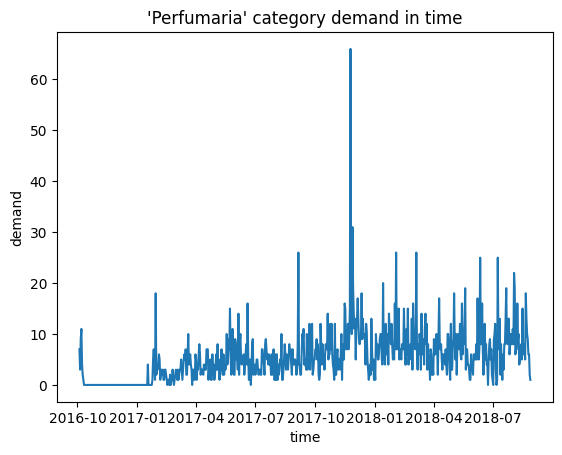

In [33]:
# Plot 
plt.plot(data['order_purchase_timestamp'], data['order_item_id'])
plt.title("'Perfumaria' category demand in time")
plt.xlabel("time")
plt.ylabel("demand")
plt.show()

In [34]:
# Grouped by days data
data.head(10)

,order_purchase_timestamp,order_item_id,items_mean_price,geolocation_lat_mean,geolocation_lng_mean
0,2016-10-04,7.0,166.328571,-19.399829,-44.808555
1,2016-10-05,3.0,186.566667,-15.863661,-42.478447
2,2016-10-06,9.0,221.137500,-21.228302,-46.210940
3,2016-10-07,11.0,186.487500,-23.849900,-44.654380
4,2016-10-08,4.0,249.900000,-17.715917,-45.322699
5,2016-10-09,2.0,35.900000,-23.196110,-46.164414
6,2016-10-10,1.0,16.900000,-23.198008,-45.888888
7,2016-10-11,0.0,0.000000,0.000000,0.000000
8,2016-10-12,0.0,0.000000,0.000000,0.000000
9,2016-10-13,0.0,0.000000,0.000000,0.000000


In [35]:
def build_target_features(data, lags, horizon=1):
    
    # Add lagged order items' number
    feat = pd.concat(
        [
            data[["order_item_id"]].shift(lag).rename(
                columns={"order_item_id": f"lag_{lag}"}
            )
            for lag in lags
        ],
        axis=1,
    )

    # Add mean price feature for lags amount of days
    price_lags = pd.concat(
        [
            data[["items_mean_price"]].shift(lag).rename(
                columns={"items_mean_price": f"price_lag_{lag}"}
            )
            for lag in lags
        ],
        axis=1)
    price_lags["mean_price"] = price_lags.mean(axis=1)

    # Add mean lat feature for lags amount of days
    lat_lags = pd.concat(
        [
            data[["geolocation_lat_mean"]].shift(lag).rename(
                columns={"geolocation_lat_mean": f"lat_lag_{lag}"}
            )
            for lag in lags
        ],
        axis=1)
    lat_lags["geolocation_lat_mean"] = lat_lags.mean(axis=1)

    # Add mean lng feature for lags amount of days
    lng_lags = pd.concat(
        [
            data[["geolocation_lng_mean"]].shift(lag).rename(
                columns={"geolocation_lng_mean": f"lng_lag_{lag}"}
            )
            for lag in lags
        ],
        axis=1)
    lng_lags["geolocation_lng_mean"] = lng_lags.mean(axis=1)

    # Build date features.
    feat['day'] = data['order_purchase_timestamp'].dt.day
    feat['month'] = data['order_purchase_timestamp'].dt.month
    feat['year'] = data['order_purchase_timestamp'].dt.year

    feat = pd.concat([feat, price_lags["mean_price"]], axis=1)
    feat = pd.concat([feat, lat_lags["geolocation_lat_mean"]], axis=1)
    feat = pd.concat([feat, lng_lags["geolocation_lng_mean"]], axis=1)
    
    # Build target at horizon.
    targ = data["order_item_id"].shift(-horizon).rename(f"horizon_{horizon}")
    
    # Drop missing values generated by lags/horizon.
    idx = ~(feat.isnull().any(axis=1) | targ.isnull())
    feat = feat.loc[idx]
    targ = targ.loc[idx]
    
    return targ, feat

In [36]:
# Build targets and features.
target, features = build_target_features(
    data,
    lags=[x for x in range(0, 7)],
    horizon=1,
)

In [37]:
# Show targets
target.head()

6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: horizon_1, dtype: float64

In [38]:
# Show features
features.head()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,day,month,year,mean_price,geolocation_lat_mean,geolocation_lng_mean
6,1.0,2.0,4.0,11.0,9.0,3.0,7.0,10,10,2016,151.888605,-20.635961,-45.075475
7,0.0,1.0,2.0,4.0,11.0,9.0,3.0,11,10,2016,128.127381,-17.864557,-38.674253
8,0.0,0.0,1.0,2.0,4.0,11.0,9.0,12,10,2016,101.475000,-15.598320,-32.605903
9,0.0,0.0,0.0,1.0,2.0,4.0,11.0,13,10,2016,69.883929,-12.565705,-26.004340
10,0.0,0.0,0.0,0.0,1.0,2.0,4.0,14,10,2016,43.242857,-9.158576,-19.625143


In [39]:
def run_backtest(model,
                 target,
                 features,
                 start_window = 10,
                 retrain_frequency = 6):
    
    # Check on shape
    assert features.shape[0] == target.shape[0]
    
    all_preds = []
    all_targets = []
    last_timestep = start_window

    while last_timestep < len(target):
        # Split train/valid
        targ_train = target.iloc[:last_timestep]
        feat_train = features.iloc[:last_timestep]
        targ_valid = target.iloc[last_timestep:last_timestep+1]    
        feat_valid = features.iloc[last_timestep:last_timestep+1]

        # Train the model
        if last_timestep==start_window or last_timestep % retrain_frequency == 0:
            model.fit(feat_train,targ_train)
        # Predict on valid set
        pred_valid = model.predict(feat_valid)
        # Save the output
        all_preds.append(pred_valid[0])
        all_targets.append(targ_valid)

        # Process next timestep
        last_timestep += 1

    # Format output
    output = pd.concat(all_targets).rename("target").to_frame()
    output["prediction"] = all_preds
    return output

In [40]:
# Apply run_backtest to our data.
output_backtest = run_backtest(
    LGBMRegressor(min_child_samples=1, objective="mae"),
    target,
    features,
    start_window = 36,
    retrain_frequency = 6,
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training be

In [41]:
# Then, let's compute the MAE.
MAE = abs(output_backtest.prediction - output_backtest.target).mean()
print(f"MAE: {MAE:.2f}")

MAE: 2.90


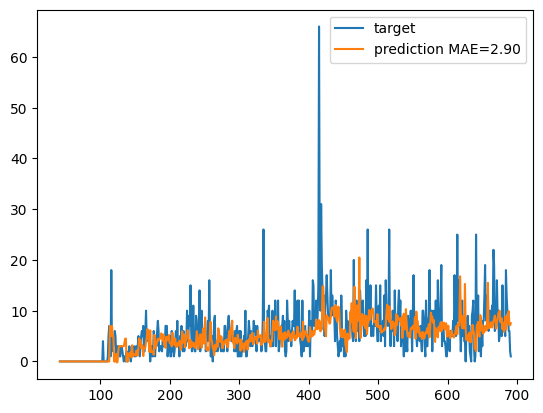

In [42]:
# Visualization of backtesting results
plt.plot(output_backtest.target, label='target')
plt.plot(output_backtest.prediction, label=f'prediction MAE={MAE:.2f}')
plt.legend()
plt.show()

### Forecasting demand for any group

In [43]:
def fill_missed_dates(data):
    # Fill dataframe with missed dates
    start_date = data["order_purchase_timestamp"].min()
    end_date = data["order_purchase_timestamp"].max()
    date_range = pd.date_range(start=start_date, end=end_date).to_frame(index=False, name='order_purchase_timestamp')
    date_range = date_range.merge(data, on='order_purchase_timestamp', how='left')
    date_range['order_item_id'] = date_range['order_item_id'].fillna(0)
    date_range['price'] = date_range['price'].fillna(0)
    date_range['items_price'] = date_range['items_price'].fillna(0)
    date_range['geolocation_lat'] = date_range['geolocation_lat'].fillna(0)
    date_range['geolocation_lng'] = date_range['geolocation_lng'].fillna(0)
    return date_range

def run_backtest_for_group(group_name):
    data = df[df['product_category_name'] == group_name]
    data = fill_missed_dates(data)
    
    # Group dataframe data by dates
    cols_to_show = ['order_item_id', 'items_price', 'geolocation_lat', 'geolocation_lng']
    # Find number of items, mean items' price, mean geolocations' lat and lng
    data = data.groupby(["order_purchase_timestamp"])[cols_to_show].agg({'order_item_id': ['sum'], 'items_price': ['mean'], 'geolocation_lat': ['mean'],'geolocation_lng': ['mean']}).reset_index()
    # Flat columns' names after grouping
    data.columns = list(map(''.join, data.columns.values))
    data = data.rename(columns={"order_item_idsum": "order_item_id", "items_pricemean": "items_mean_price", "geolocation_latmean": "geolocation_lat_mean", "geolocation_lngmean": "geolocation_lng_mean"})
    
    # Build targets and features.
    target, features = build_target_features(
        data,
        lags=[x for x in range(0, 7)],
        horizon=1,
    )
    
    # Apply run_backtest to our data.
    output_backtest = run_backtest(
        LGBMRegressor(min_child_samples=1, objective="mae"),
        target,
        features,
        start_window = 36,
        retrain_frequency = 6,
    )

    # Then, let's compute the MAE.
    MAE = abs(output_backtest.prediction - output_backtest.target).mean()

    plt.plot(output_backtest.target, label='target')
    plt.plot(output_backtest.prediction, label=f'prediction MAE={MAE:.2f}')
    plt.legend()
    plt.show()

# Get prediction for last 21 day (7 days + *14 days*) in dataset to compare results with actual
# data in dataset
def run_prediction_for_group(group_name, horizon=21):
    data = df[df['product_category_name'] == group_name]

    # Fill dataframe with missed dates
    data = fill_missed_dates(data)

    pred_last_day = data["order_purchase_timestamp"].iloc[-1]
    pred_first_day = data["order_purchase_timestamp"].iloc[-1] - pd.to_timedelta(horizon, unit='d')

    # Group dataframe data by dates
    cols_to_show = ['order_item_id', 'items_price', 'geolocation_lat', 'geolocation_lng']
    # Find number of items, mean items' price, mean geolocations' lat and lng
    data = data.groupby(["order_purchase_timestamp"])[cols_to_show].agg({'order_item_id': ['sum'], 'items_price': ['mean'], 'geolocation_lat': ['mean'],'geolocation_lng': ['mean']}).reset_index()
    # Flat columns' names after grouping
    data.columns = list(map(''.join, data.columns.values))
    data = data.rename(columns={"order_item_idsum": "order_item_id", "items_pricemean": "items_mean_price", "geolocation_latmean": "geolocation_lat_mean", "geolocation_lngmean": "geolocation_lng_mean"})

    # Build targets and features.
    target, features = build_target_features(
        data,
        lags=[x for x in range(0, 7)],
        horizon=1,
    )

    targ_train = target.iloc[:-horizon]
    feat_train = features.iloc[:-horizon]
    
    feat_test = features.iloc[-horizon:-1]
    targ_test = target.iloc[-horizon:-1]

    model = LGBMRegressor(min_child_samples=1, objective="mae")
    model.fit(feat_train,targ_train)

    pred_test = model.predict(feat_test)
    
    return pred_test, targ_test, pred_first_day, pred_last_day

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training be

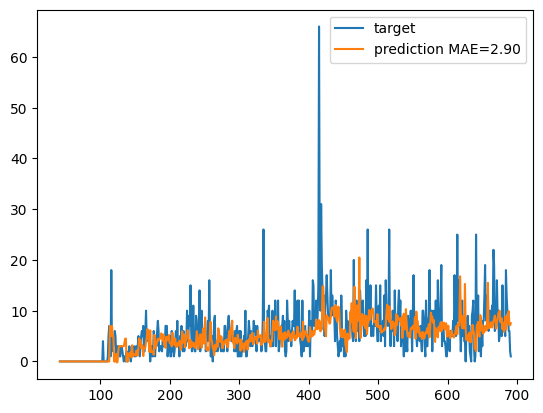

In [44]:
# Run backtest for model for perfumaria category prediction
run_backtest_for_group('perfumaria')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 664, number of used features: 13
[LightGBM] [Info] Start training from score 5.000000
3.321627096247648


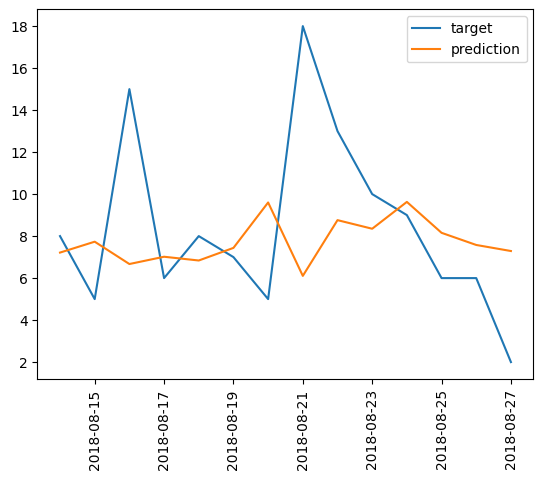

In [45]:
prediction, real, pred_first_day, pred_last_day = run_prediction_for_group('perfumaria', 22)
prediction = np.array(prediction[-14:])
real = np.array(real[-14:])

MAE = abs(prediction - real).mean()
print(MAE)

date_range = pd.date_range(start=pred_first_day, end=pred_last_day)

plt.plot(date_range.date[-14:], real, label='target')
plt.plot(date_range.date[-14:], prediction, label=f'prediction')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

***
Possible improvements:

* Better feature engineering, adding complex features. Obvious features don't provide the desired perfomance improvements.
* Better data processing.
* It can be tried Global approach to time series forecasting to improve perfomance.
***

## Task 1.2 (Classical model for time series forecasting)

In [46]:
import itertools
import warnings
# from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [47]:
warnings.filterwarnings("ignore")

### Exploring 'parfumaria' category

In [48]:
# Select perfumaria category products
data = df[df['product_category_name'] == 'perfumaria']

# Fill missed dates
data = fill_missed_dates(data)

# Group data by dates
cols_to_show = ['order_item_id']
data = data.groupby(["order_purchase_timestamp"])[cols_to_show].agg("sum")

data.head(20)

,order_item_id
order_purchase_timestamp,
2016-10-04,7.0
2016-10-05,3.0
2016-10-06,9.0
2016-10-07,11.0
2016-10-08,4.0
2016-10-09,2.0
2016-10-10,1.0
2016-10-11,0.0
2016-10-12,0.0


In [49]:
data.shape

(693, 1)

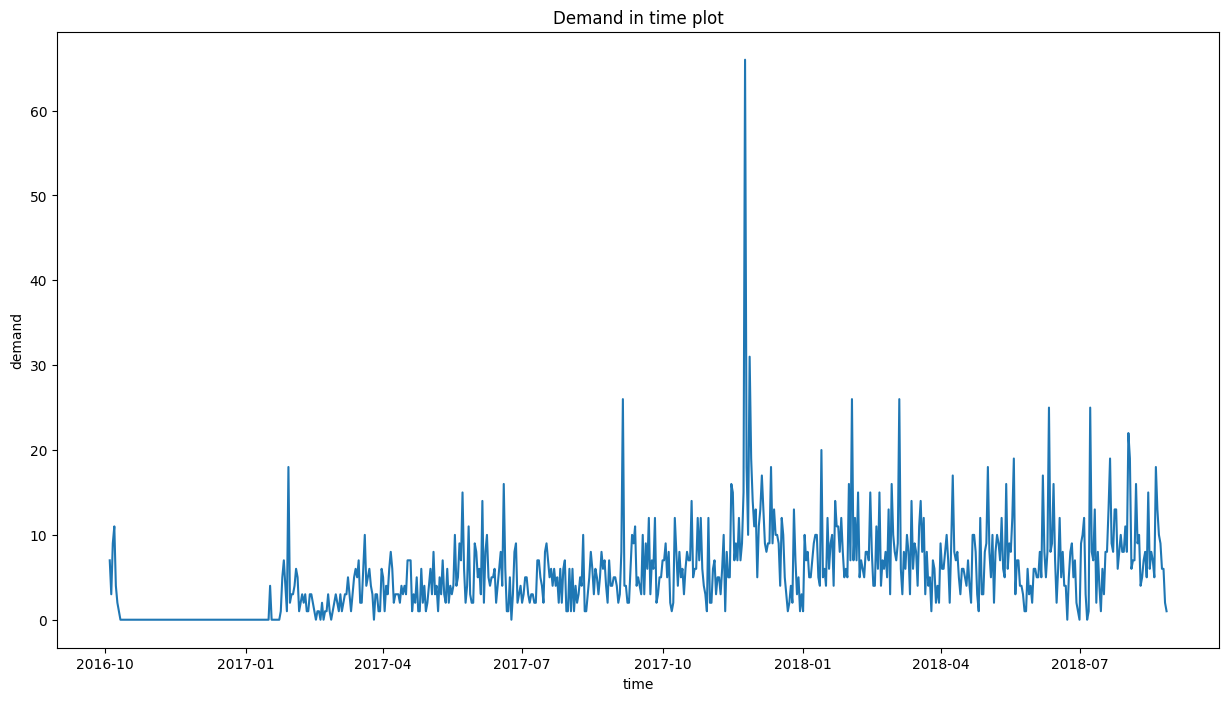

In [50]:
# Plot demand in time
plt.figure(figsize=(15,8))
plt.plot(data['order_item_id'])
plt.title('Demand in time plot')
plt.xlabel('time')
plt.ylabel('demand')
plt.show()

In [51]:
# Dickey-Fuller test to check for stationarity of a time series
print('Dickey-Fuller test:')
df_result = adfuller(data['order_item_id'])
df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
for result_value, label in zip(df_result, df_labels):
    print(label + ' : ' + str(result_value))

if df_result[1] <= 0.05:
    print("Time series is considered stationary.")
else:
    print("Time series is considered non-stationary.")

Dickey-Fuller test:
ADF Test Statistic : -4.06358658012546
p-value : 0.0011118132445751697
#Lags Used : 7
Number of Observations Used : 685
Time series is considered stationary.


***
The series is stationary, so we do not need to bring the time series to stationarity on our own. This property will give more accurate results of forecasting.
***

In [52]:
# Split train and test data
train_data = data[:-21]
test_data = data[-21:]

In [53]:
print(f"Train data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Train data size: (672, 1)
Test data size: (21, 1)


In [54]:
test_data.head(10)

,order_item_id
order_purchase_timestamp,
2018-08-07,16.0
2018-08-08,9.0
2018-08-09,10.0
2018-08-10,4.0
2018-08-11,5.0
2018-08-12,7.0
2018-08-13,8.0
2018-08-14,5.0
2018-08-15,15.0


***
As classical models we will use ARIMA and Prophet models to forecast timeseries.
***

### ARIMA model

In [55]:
# Determining the optimal values of the ARIMA model parameters for our particular dataset.
# To configure the ARIMA parameters, we will use the "grid search" method.
def search_optimal_arima(time_series):
    order_vals = diff_vals = ma_vals = range(0, 3)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
       
    smallest_aic = float("inf")
    optimal_order_param = None

    for order_param in pdq_combinations:
        try:
            model = ARIMA(time_series, order=order_param)

            model_results = model.fit()
            if model_results.aic < smallest_aic:
                smallest_aic = model_results.aic
                optimal_order_param = order_param
        except:
            continue

    print(f'ARIMA{optimal_order_param} - AIC:{smallest_aic}')
    return optimal_order_param

In [56]:
# Find optimal parameters for ARIMA model
arima_order_params = search_optimal_arima(train_data)

ARIMA(0, 1, 2) - AIC:3884.2033545852273


In [57]:
# Initialize model
model = ARIMA(train_data, order=arima_order_params)
# Model training
results = model.fit()
# Print perfomance report
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:          order_item_id   No. Observations:                  672
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1939.102
Date:                Sat, 13 Jul 2024   AIC                           3884.203
Time:                        12:24:20   BIC                           3897.730
Sample:                    10-04-2016   HQIC                          3889.442
                         - 08-06-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8032      0.043    -18.775      0.000      -0.887      -0.719
ma.L2         -0.0677      0.038     -1.766      0.077      -0.143       0.007
sigma2        18.9126      0.300     63.127      0.0

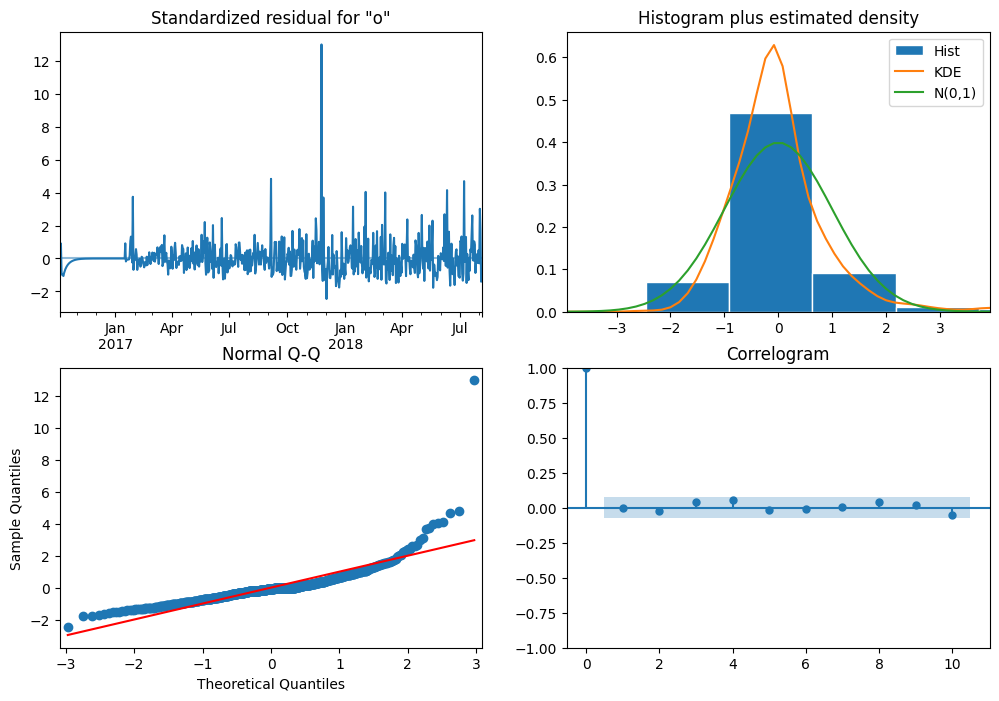

In [58]:
# Visualization of model diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

***
Four graphs are created:
* The residual curve. If the model is good, the residuals will be random and the plot will look like white noise.
* Q-Q plot. Compares the distribution of residuals to a perfect normal distribution. The points follow a diagonal line -> the residuals are normally distributed.
* A correlogram plot. If the model is good, the residuals will not correlate with each other. The absence of blue bars outside the blue noise range indicates this.
* The histogram of the distribution of residuals. If the model is good, the residuals should be normally distributed.
***
***
We have selected a model that generally meets the requirements, however, the potential to improve the parameters of the seasonal ARIMA model is still present.
***

In [59]:
# Comparison of forecast values with real data

In [60]:
st_pred = results.get_prediction(
    start=pd.to_datetime('2018-08-07') + pd.to_timedelta(7, unit='d'),
    end=pd.to_datetime('2018-08-07') + pd.to_timedelta(20, unit='d'),
    dynamic=False) 
forecast_values = st_pred.predicted_mean

In [61]:
actual_values = test_data[-14:]
forecast_mae = abs(forecast_values-actual_values["order_item_id"]).mean()
print(f'MAE: {forecast_mae}')

MAE: 4.349700742047061


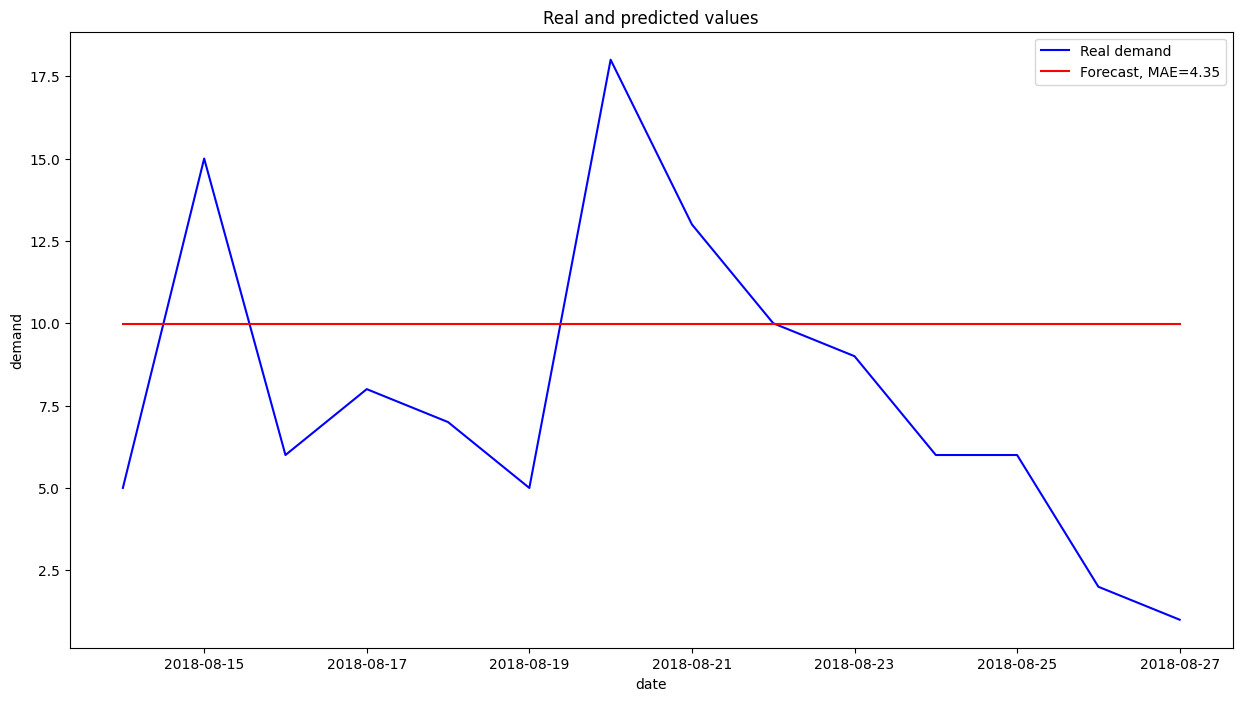

In [62]:
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Real demand', color='blue')

plt.plot(forecast_values.index, forecast_values, label=f'Forecast, MAE={forecast_mae:.2f}', color='red')

plt.title('Real and predicted values')
plt.xlabel('date')
plt.ylabel('demand')
plt.legend()

plt.show()

### Prophet model

In [63]:
train = train_data.copy()
test = test_data.copy()
train = train.reset_index()
test = test.reset_index()
train.columns = ['ds', 'y']
test.columns = ['ds', 'y']

In [64]:
# Init Prophet model
m = Prophet()
# Model train
m.fit(train)

12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
# Forecasting
future = m.make_future_dataframe(periods=21)
forecast = m.predict(future)

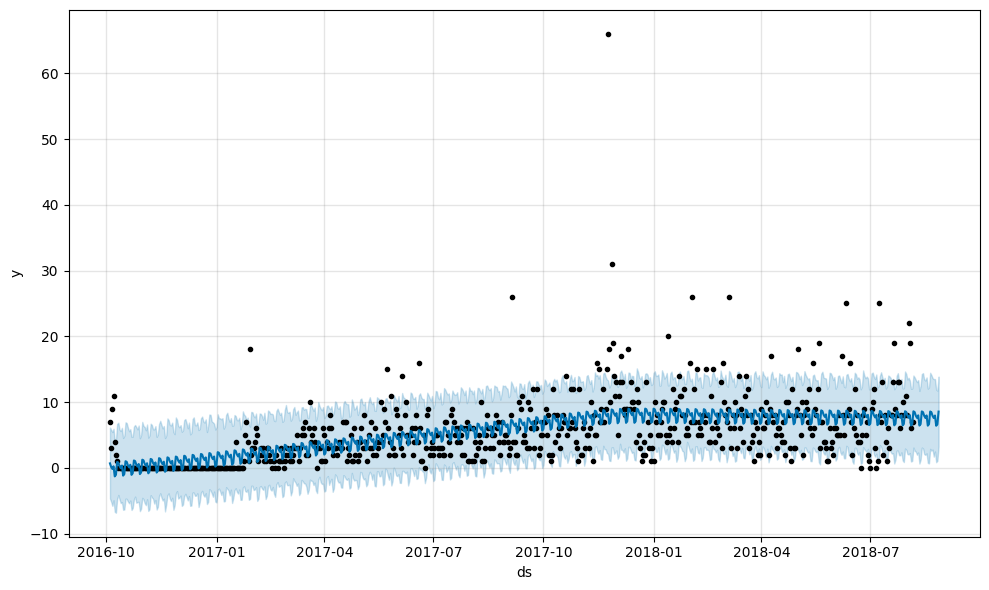

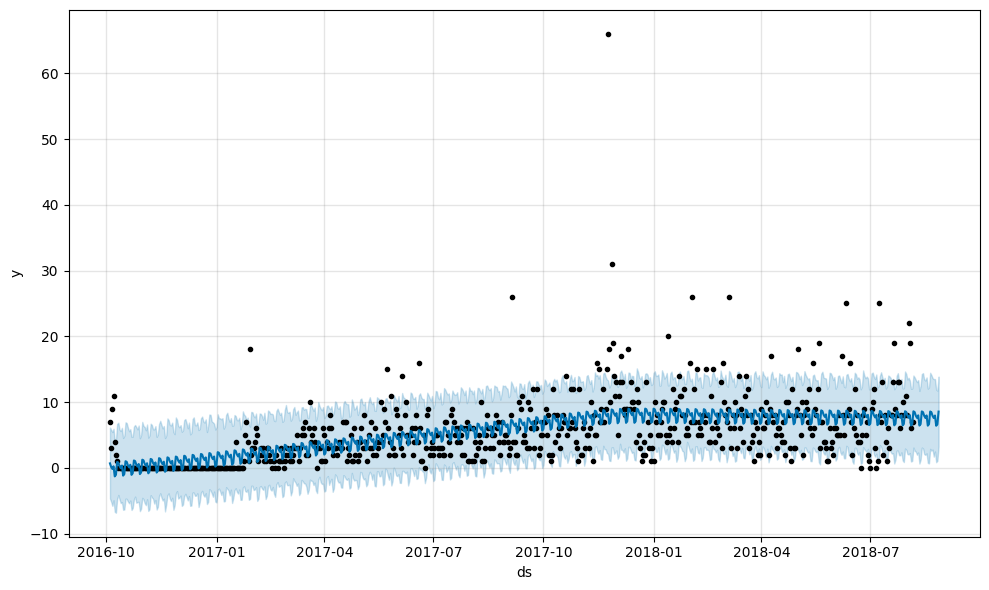

In [66]:
# Plot model forecast
m.plot(forecast)

In [67]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [68]:
forecast = forecast[-21:].reset_index()[["ds", "yhat"]]
forecast.head()

,ds,yhat
0,2018-08-07,8.481624
1,2018-08-08,7.926342
2,2018-08-09,7.600279
3,2018-08-10,7.982675
4,2018-08-11,6.427608


In [69]:
actual_values.head()

,order_item_id
order_purchase_timestamp,
2018-08-14,5.0
2018-08-15,15.0
2018-08-16,6.0
2018-08-17,8.0
2018-08-18,7.0


In [70]:
# Find MAE score
actual_values = test_data
forecast_mae = abs(forecast["yhat"]-test["y"]).mean()
print(f'MAE: {forecast_mae}')

MAE: 3.036557776143292


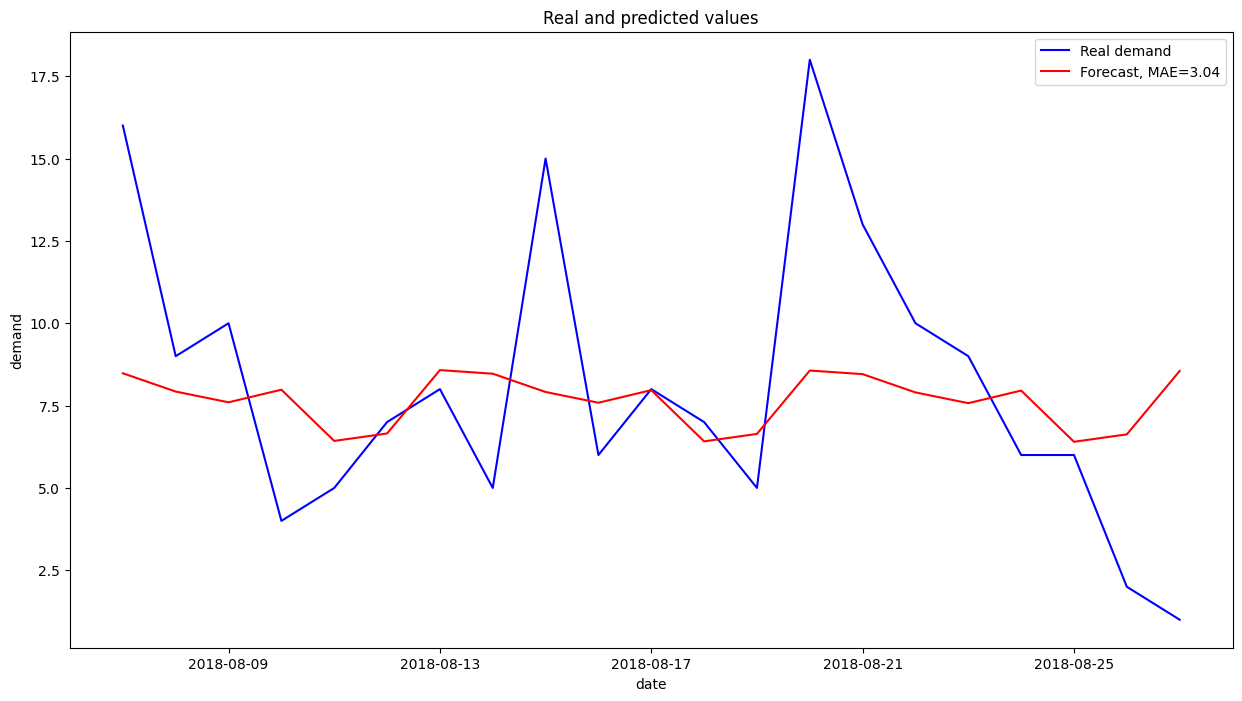

In [71]:
# Plot real data and prediction
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Real demand', color='blue')

plt.plot(forecast.ds, forecast.yhat, label=f'Forecast, MAE={forecast_mae:.2f}', color='red')

plt.title('Real and predicted values')
plt.xlabel('date')
plt.ylabel('demand')
plt.legend()

plt.show()

***
We see that Prophet shows better perfomance, so consider using Prophet model for categories sales forecasting.
***

### Forecasting for any group

In [72]:
# Function for demand forecasting for specific group (category)
def get_prophet_prediction_for_group(group_name, horizon=21):
    # Select group (category) products
    data = df[df['product_category_name'] == group_name]
    
    # Fill missed dates
    data = fill_missed_dates(data)
    
    # Group data by dates
    cols_to_show = ['order_item_id']
    data = data.groupby(["order_purchase_timestamp"])[cols_to_show].agg("sum").reset_index()
    data.columns = ['ds', 'y']

    # Init Prophet model
    m = Prophet()
    # Model train
    m.fit(data)

    future = m.make_future_dataframe(periods=horizon)
    forecast = m.predict(future)

    return forecast[-horizon:][["ds", "yhat"]]

In [73]:
# Example of usage
forecast = get_prophet_prediction_for_group("perfumaria", 21)

12:24:25 - cmdstanpy - INFO - Chain [1] start processing
12:24:25 - cmdstanpy - INFO - Chain [1] done processing


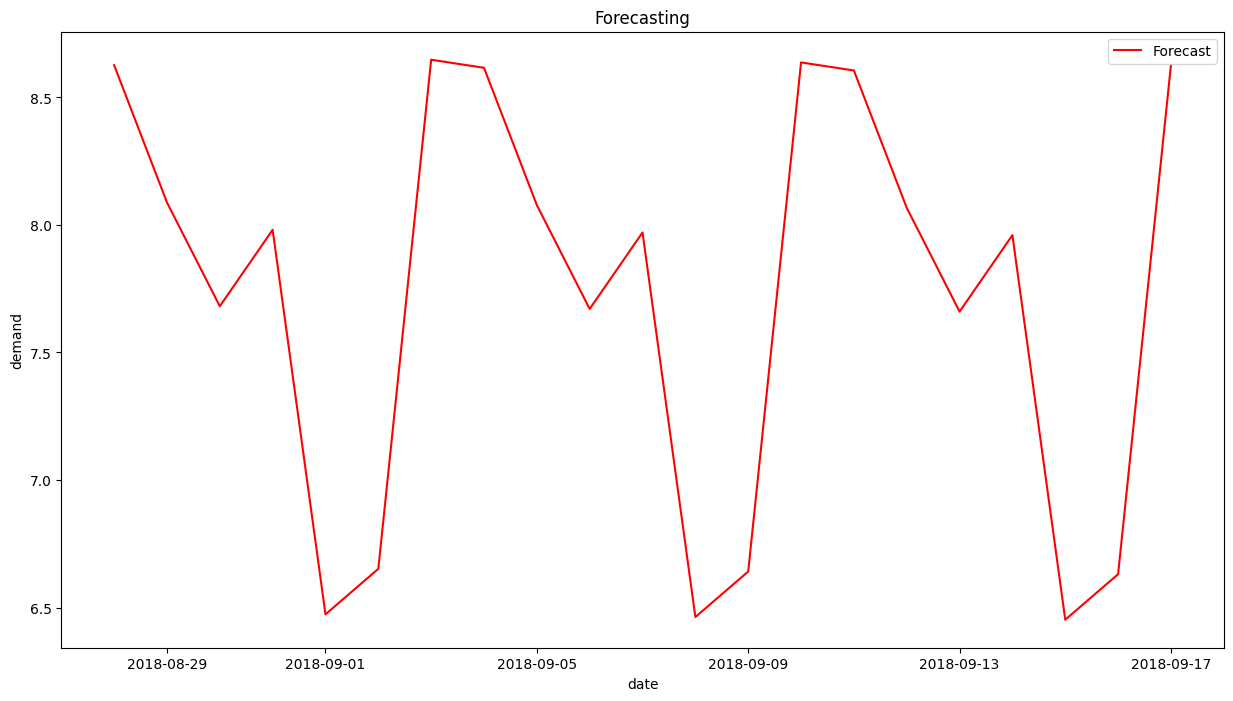

In [74]:
# Plot forecast
plt.figure(figsize=(15,8))
plt.plot(forecast.ds, forecast.yhat, label=f'Forecast', color='red')
plt.title('Forecasting')
plt.xlabel('date')
plt.ylabel('demand')
plt.legend()

plt.show()